# Diffusion as a Stochastic Process

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [43]:
X = np.zeros((102,102))

In [44]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [45]:
X.shape

(102, 102)

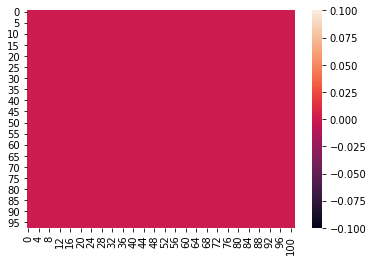

In [46]:
sns.heatmap(X[1:100][1:100])

In [47]:
for i in range(400):
    i,j = np.random.randint(1,101), np.random.randint(1,101)
    X[i][j] = X[i][j] + 1

In [48]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

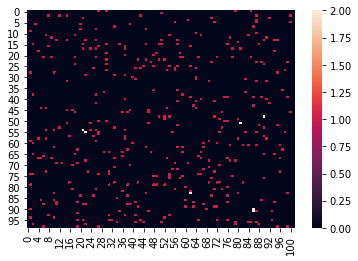

In [49]:
sns.heatmap(X[1:101][1:101])

### Actualización de Condiciones Periódicas

In [50]:
for j in range(1,101):
    X[0][j] = X[100][j]
    X[101][j] = X[1][j]
    X[j][0] = X[j][100]
    X[j][101] = X[j][1]

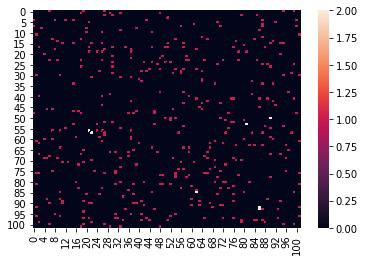

In [52]:
sns.heatmap(X[:][:])

### Ley de Fick

El flujo de partículas es proporcional al gradiente de concentración

$$J(\mathbf{x},t) = - D \nabla c(\mathbf{x}, t)$$

Número de partículas que cruzan, por unidad de área, por unidad de tiempo. Entonces $A J$ es el número de partículas por unidad de tiempo que están atravesando la "ventana" de tamaño $A$.

Para implementar el algoritmo, debemos calcular la probabilidades por unidad de tiempo de moverse las partículas a regiones contiguas. Para ello, usamos una versión discreta de la ley de Fick

$$a(s,d,i,j) =  - A D \frac{\left [X(s,i + 1,j)/L^3 - X(s, i,j)/L^3 \right ]}{L}$$

$$[D] = \frac{L^2}{s}$$

en donde $d$ indica la dirección en la que se movería la partícula, en este caso a la derecha; cada partícula tiene 4 grados de libertad. Esto es, aquí la clave de poder considerar la difusión como un procesos análogo a las reacciones químicas (desde el punto de vista probabilístico), es que cada posibilidad de movimiento es análogo o equivalente a la posibilidad de una transmutación química.


En un espacio de dos dimensiones, hay 4 posibilidades para cada molécula o partícula; hay que ponderarlas todas

In [63]:
D = 1

In [70]:
a = np.zeros((4,101,101))

### Cálculo de las "propensiones" $a(s,d,i,j)$

In [71]:
for i in range(1,101):
    for j in range(1,101):
        a[0][i][j] = D*(X[i][j] - X[i - 1][j])
        if a[0][i][j] < 0:
            a[0][i][j] = 0
        a[1][i][j] = D*(X[i][j] - X[i + 1][j])
        if a[1][i][j] < 0:
            a[1][i][j] = 0
        a[2][i][j] = D*(X[i][j] - X[i][j - 1])
        if a[2][i][j] < 0:
            a[2][i][j] = 0
        a[3][i][j] = D*(X[i][j] - X[i - 1][j + 1])
        if a[3][i][j] < 0:
            a[3][i][j] = 0

### Rutina Montecarlo para el algoritmo de Gillespie

$$P(\tau, \mu, i, j) = a(\mu, i, j)\, \exp{-[\sum_{\mu i j} a(\mu, i ,j)] \tau ]}$$

$$P(\tau, \mu, i, j) = P_1(\tau) P_2(\mu, i, j| \tau)$$

$$P_1(\tau)= \exp{-[\sum_{\mu i j} a(\mu, i ,j)] \tau ]}  \sum_{\mu i j} a(\mu, i, j)$$

$$P_2(\mu, i, j| \tau) = \frac{a( \mu, i, j)}{\sum_{\mu i j} a(\mu, i, j)}$$

$$P_3(\mu |\tau) = \sum_{i j} P_2(\mu, i, j | \tau) = \frac{\sum_{i j} a( \mu, i, j)}{\sum_{\mu i j} a(\mu, i, j)}$$


$$P_4(\mu, i |\tau) = \sum_{j} P_2(\mu,i,j|\tau) = \sum_{j} \left [\frac{a(\mu,i,j)}{\sum_{\mu, i, j} a(\mu,i,j)}   \right ]$$

$$P_5(\mu, j | \tau) = \sum_{i} P_2(\mu,i,j|\tau) = \sum_{j} \left [\frac{a(\mu,i,j)}{\sum_{\mu, i, j} a(\mu,i,j)}   \right ]$$

In [88]:
P2 = np.zeros((4,101,101))
P3 = np.zeros((4))
P4 = np.zeros((4,101))
P5 = np.zeros((4,101))

In [165]:
def fun_a0(a):
    a0 = 0
    for d in range(0,4):
        for i in range(1,101):
            for j in range(1,101):
                a0 = a0 + a[d][i][j]
    return a0

In [166]:
fun_a0(a)

1542.0

In [91]:
for mu in range(4):
    for i in range(1,101):
        for j in range(1,101):
            P2[mu][i][j] = a[d][i][j]/a0

In [92]:
for mu in range(4):
    suma_mu = 0
    for i in range(1,101):
        for j in range(1,101):
            suma_mu = suma_mu + P2[mu][i][j]
    P3[mu] = suma_mu

In [96]:
for mu in range(4):
    for i in range(1,101):
        suma_j = 0
        for j in range(1,101):
            suma_j = suma_j + P2[mu,i,j]
        P4[mu][i] = suma_j

In [97]:
for mu in range(4):
    for j in range(1,101):
        suma_i = 0
        for i in range(1,101):
            suma_i = suma_i + P2[mu,i,j]
        P5[mu][j] = suma_i

### Función que actualiza las probabilidades

In [494]:
def act_probs(a,a0,P2,P3,P4,P5):

    for mu in range(4):
        for i in range(1,101):
            for j in range(1,101):
                P2[mu][i][j] = a[mu][i][j]/a0
                
    for mu in range(4):
        suma_mu = 0
        for i in range(1,101):
            for j in range(1,101):
                suma_mu = suma_mu + P2[mu][i][j]
        P3[mu] = suma_mu
        
    for mu in range(4):
        for i in range(1,101):
            suma_j = 0
            for j in range(1,101):
                suma_j = suma_j + P2[mu,i,j]
            P4[mu][i] = suma_j
    for mu in range(4):
        for j in range(1,101):
            suma_i = 0
            for i in range(1,101):
                suma_i = suma_i + P2[mu,i,j]
            P5[mu][j] = suma_i
    return P2, P3, P4, P5

### Algoritmo de Gillespie generalizado a ambientes anisotrópicos

$$\tau = \frac{1}{a_0} \ln{\left (\frac{1}{r1}\right )}$$

$$\sum_{\nu=1}^{\mu -1} P_3(\nu|\tau) < r2 \le \sum_{\nu=1}^{\mu} P_3(\nu|\tau)$$


$$\sum_{i=1}^{i* -1} P_4(\nu, i|\tau) < r3*P_3(\mu |\tau) \le \sum_{i = 1}^{i*} P_3(\mu, i|\tau)$$


$$\sum_{j=1}^{j* -1} P_5(\nu, j|\tau) < r4*P_3(\mu |\tau) \le \sum_{j = 1}^{j*} P_5(\mu, j|\tau)$$

Tenemos que elegir un cuarteto de números $\tau$, el intervalo de tiempo, $\mu$ el procesos (reacción-difusión), $i$ el renglón en la mala y $j$ la columna en la malla.

In [222]:
def fun_mu(P3,r2):
    suma_mu = 0
    for nu in range(4):
        suma_mu = suma_mu + P3[nu]
        if suma_mu <= r2:
            return nu
    return nu

In [490]:
def fun_i(P3,P4,r3,mu):
    suma_i = 0
    for i_star in range(1,101):
        suma_i = suma_i + P4[mu][i_star]
        if suma_i >= r3*P3[mu]:
            return i_star
    return i_star

In [495]:
def fun_j(P3,P5,r4,mu):
    suma_j = 0
    for j_star in range(1,101):
        suma_j = suma_j + P5[mu][j_star]
        if suma_j >= r4*P3[mu][j_star]:
            return j_star
    return j_star

In [225]:
fun_mu(P3,r2)

3

In [226]:
fun_i(P3,P4,np.random.rand(),fun_mu(P3,r2))

1

In [227]:
fun_j(P3,P5,np.random.rand(),fun_mu(P3,r2))

1

In [228]:
mu

1

In [155]:
fun_j(P3,P5,np.random.rand(),1)

100

In [229]:
def fun_act_dif(X, mu, i, j):
    if mu == 0:
        X[i,j] = X[i,j] - 1
        X[i - 1,j] = X[i - 1,j] + 1
    # Difusion hacia abajo    
    elif mu == 1:
        X[i,j] = X[i,j] - 1
        X[i + 1,j] = X[i + 1,j] + 1
    # Difusion hacia la izquierda
    elif mu == 2:
        X[i,j] = X[i,j] - 1
        X[i,j - 1] = X[i,j - 1] + 1
    # Difusion hacia la derecha
    else:
        X[i,j] = X[i,j] - 1
        X[i,j + 1] = X[i,j + 1] + 1
    return X

In [242]:
def paso_montecarlo(X, a, t, P2, P3, P4, P5):
    
    r1 = np.random.rand()
    r2 = np.random.rand()
    r3 = np.random.rand()
    r4 = np.random.rand()
    
    #mu = 0
    
    a0 = fun_a0(a)
    
    #Calculo del intervalo tau
    
    if a0 != 0:
        tau = (1./a0)*np.log(1/r1)
    else:
        tau = 1000
    
    #Actualizamos el tiempo
    
    if tau != 0:
                
        t = t + tau
    
    
    #Calculo reaccion-difusion
    
    mu = fun_mu(P3,r2)
    
    #Calculo del renglon
    
    i = fun_i(P3,P4,r3,mu)
    
    #Calculo de la columna
    
    j = fun_j(P3,P5,r4,mu)
    
    print(tau,mu,i,j)
    
    #Actualizamos el vector de concentracion de acurdo con el tipo de proceso
    #que ocurre

    
    X = fun_act_dif(X, mu, i, j)
    
    X = func_act_CC(X)

        
    #actualizamos las as
    
    a = actualizacion_as(a, X)
    
    #actualizamos las Ps
    P2, P3, P4, P5 = act_probs(a,a0,P2,P3,P4,P5)
    
    return t, X, a, P2, P3, P4, P5

### Tests

In [421]:
X0 = np.zeros((102,102))

In [422]:
X0

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [423]:
for i in range(25,51):
    for j in range(25,51):
        X0[i][j] = 40

In [424]:
def func_act_CC(X0):
    for j in range(1,101):
        X0[0][j] = X0[100][j]
        X0[101][j] = X0[1][j]
        X0[j][0] = X0[j][100]
        X0[j][101] = X0[j][1]
    return X0

In [425]:
X0 = func_act_CC(X0)

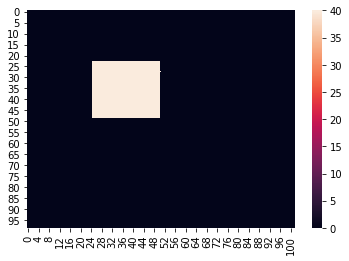

In [426]:
sns.heatmap(X0[1:101][1:101])

In [456]:
a = np.zeros((4,102,102))

In [457]:
def actualizacion_as(a, X):
    for i in range(1,101):
        for j in range(1,101):
            a[0][i][j] =  D*(X[i][j] - X[i - 1][j])
            if a[0][i][j] < 0:
                a[0][i][j] = 0
            a[1][i][j] =  D*(X[i][j] - X[i + 1][j])
            if a[1][i][j] < 0:
                a[1][i][j] = 0
            a[2][i][j] =  D*(X[i][j] - X[i][j - 1])
            if a[2][i][j] < 0:
                a[2][i][j] = 0
            a[3][i][j] =  D*(X[i][j] - X[i][j + 1])
            if a[3][i][j] < 0:
                a[3][i][j] = 0
    return a

In [458]:
a = actualizacion_as(a,X0)

In [496]:
r1 = np.random.rand()
r2 = np.random.rand()
r3 = np.random.rand()
r4 = np.random.rand()

mu = fun_mu(P3,r2)
    
#Calculo del renglon

i = fun_i(P3,P4,r3,mu)

#Calculo de la columna

j = fun_j(P3,P5,r4,mu)

IndexError: invalid index to scalar variable.

In [497]:
fun_j(P3,P5,r4,mu)

IndexError: invalid index to scalar variable.

In [487]:
mu,i,j

(0, 25, 1)

In [463]:
P2 = np.zeros((4,102,102))
P3 = np.zeros((4))
P4 = np.zeros((4,102))
P5 = np.zeros((4,102))

In [464]:
P2, P3, P4, P5 = act_probs(a,a0,P2,P3,P4,P5)

In [465]:
P3

array([0.67444877, 0.67444877, 0.67444877, 0.67444877])

#### Está mal actualizada $P_3(\mu|\tau)$ porque $a(\mu,i,j)$ no estaba operando bien

In [485]:
for i in range(20,56):
    print(P2[3][i][50])

0.0
0.0
0.0
0.0
0.0
0.02594033722438392
0.02594033722438392
0.02594033722438392
0.02594033722438392
0.02594033722438392
0.02594033722438392
0.02594033722438392
0.02594033722438392
0.02594033722438392
0.02594033722438392
0.02594033722438392
0.02594033722438392
0.02594033722438392
0.02594033722438392
0.02594033722438392
0.02594033722438392
0.02594033722438392
0.02594033722438392
0.02594033722438392
0.02594033722438392
0.02594033722438392
0.02594033722438392
0.02594033722438392
0.02594033722438392
0.02594033722438392
0.02594033722438392
0.0
0.0
0.0
0.0
0.0


#### Is it $a(\mu,i,j)$ well calculated?

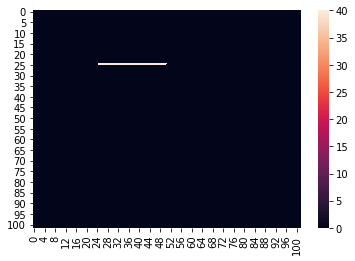

In [459]:
sns.heatmap(a[0][:][:])

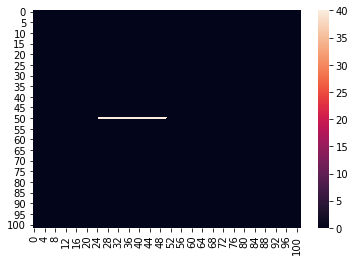

In [460]:
sns.heatmap(a[1][:][:])

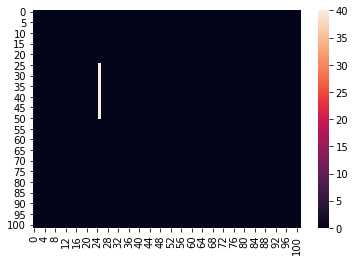

In [461]:
sns.heatmap(a[2][:][:])

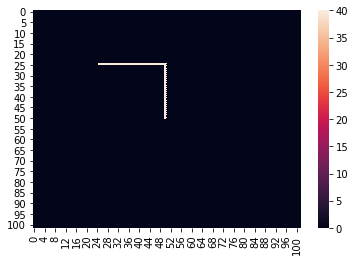

In [443]:
sns.heatmap(a[3][:][:])

#### Is not!!!

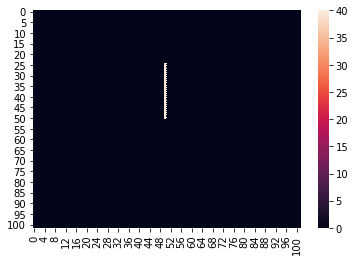

In [462]:
sns.heatmap(a[3][:][:])

In [481]:
P2[0][25][26]

0.02594033722438392

#### $P_2(\mu | \tau)$ is well calculated...is it!?

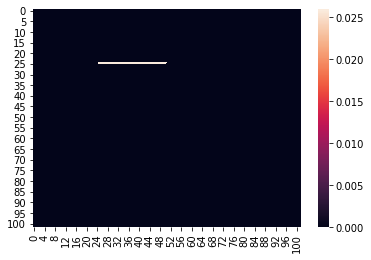

In [479]:
sns.heatmap(P2[0][:][:])

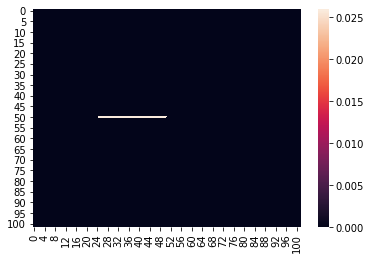

In [470]:
sns.heatmap(P2[1][:][:])

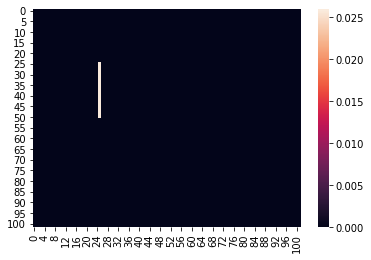

In [471]:
sns.heatmap(P2[2][:][:])

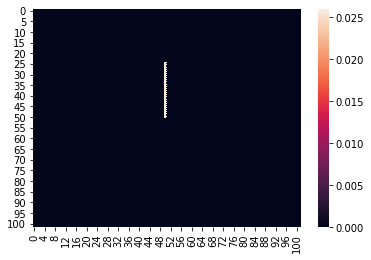

In [472]:
sns.heatmap(P2[3][:][:])

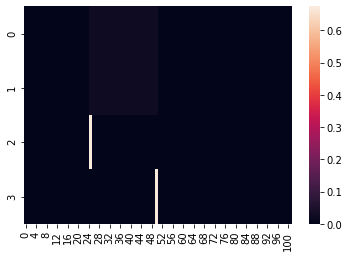

In [503]:
sns.heatmap(P5)

In [474]:
for i in range(100):
    r2 = np.random.rand()
    mu = fun_mu(P3,r2)
    print(mu)

3
3
3
3
0
3
0
0
3
3
0
3
3
3
0
3
3
3
0
3
0
3
3
3
3
3
0
0
0
3
3
3
0
0
3
3
3
0
3
3
3
3
3
3
3
3
3
3
3
0
3
3
3
0
3
3
3
0
3
3
0
0
0
0
3
3
3
3
3
0
3
3
3
0
3
0
0
3
3
0
0
3
3
3
3
3
3
3
0
3
0
3
3
3
3
0
0
3
0
0


In [373]:
X0[27][1]

0.0

In [374]:
X0[28][1]

0.0

In [376]:
a[3][28][1]

0.0

In [377]:
a

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [ ]:
X0 = fun_act_dif(X0, mu, i, j)

### Simulación

0.000799107015191722 3 25 1


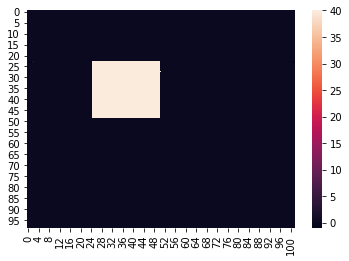

8.749747471716948e-05 0 29 1


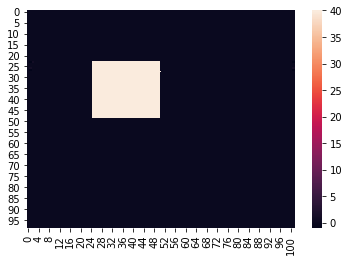

0.00010770968231068214 0 25 1


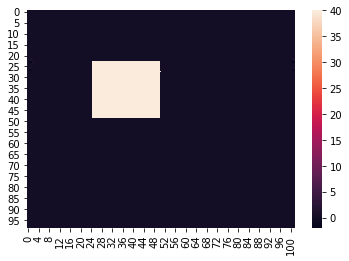

9.987140087021161e-05 0 25 1


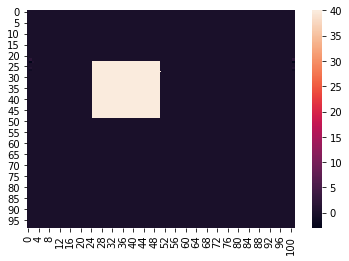

0.000215357615716042 3 25 1


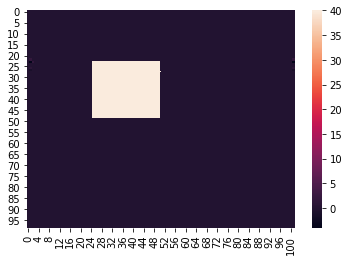

4.8623842580893645e-05 0 44 1


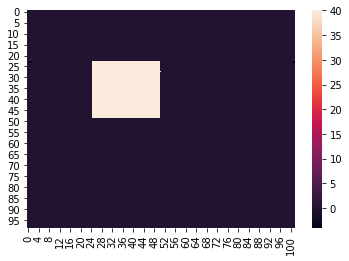

0.0002267972384277956 0 31 1


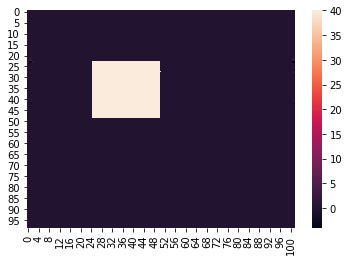

0.000261677437088145 3 25 1


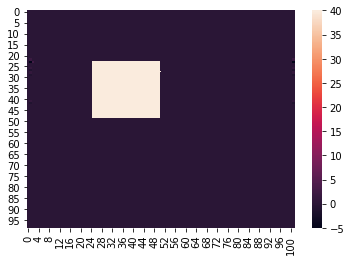

0.00029613558535308056 0 25 1


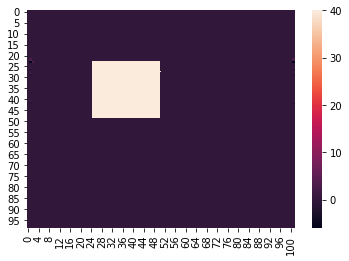

0.000182279098805564 3 25 1


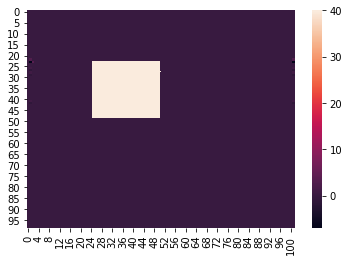

In [355]:
N_pasos = 10


a = np.zeros((4,102,102))
P2 = np.zeros((4,102,102))
P3 = np.zeros((4))
P4 = np.zeros((4,102))
P5 = np.zeros((4,102))

t = 0

a = actualizacion_as(a,X0)

tiempos = [0]



P2, P3, P4, P5 = act_probs(a,a0,P2,P3,P4,P5)


for i in range(0,N_pasos):
    t, X0, a, P2, P3, P4, P5 = paso_montecarlo(X0, a, t, P2, P3, P4, P5)
    tiempos.append(t)
    sns.heatmap(X0[1:101][1:101])
    plt.show()

In [356]:
tiempos

[0,
 0.000799107015191722,
 0.0008866044899088915,
 0.0009943141722195737,
 0.0010941855730897854,
 0.0013095431888058273,
 0.0013581670313867209,
 0.0015849642698145166,
 0.0018466417069026616,
 0.0021427772922557424,
 0.0023250563910613064]

In [359]:
X0[X0 < 0]

array([-7., -7., -1., -1., -1., -1., -1., -1.])

### Pruebas

In [346]:
def actualizacion_as(a, X):
    for i in range(1,101):
        for j in range(1,101):
            a[0][i][j] =  D*(X[i][j] - X[i - 1][j])
            if a[0][i][j] < 0:
                a[0][i][j] = 0
            a[1][i][j] =  D*(X[i][j] - X[i + 1][j])
            if a[1][i][j] < 0:
                a[1][i][j] = 0
            a[2][i][j] =  D*(X[i][j] - X[i][j - 1])
            if a[2][i][j] < 0:
                a[2][i][j] = 0
            a[3][i][j] =  D*(X[i][j] - X[i - 1][j + 1])
            if a[3][i][j] < 0:
                a[3][i][j] = 0
            print(i,j)
    return a

In [347]:
actualizacion_as(a,X0)

1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 77
1 78
1 79
1 80
1 81
1 82
1 83
1 84
1 85
1 86
1 87
1 88
1 89
1 90
1 91
1 92
1 93
1 94
1 95
1 96
1 97
1 98
1 99
1 100
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
2 41
2 42
2 43
2 44
2 45
2 46
2 47
2 48
2 49
2 50
2 51
2 52
2 53
2 54
2 55
2 56
2 57
2 58
2 59
2 60
2 61
2 62
2 63
2 64
2 65
2 66
2 67
2 68
2 69
2 70
2 71
2 72
2 73
2 74
2 75
2 76
2 77
2 78
2 79
2 80
2 81
2 82
2 83
2 84
2 85
2 86
2 87
2 88
2 89
2 90
2 91
2 92
2 93
2 94
2 95
2 96
2 97
2 98
2 99
2 100
3 1
3 2
3 3
3 4


19 18
19 19
19 20
19 21
19 22
19 23
19 24
19 25
19 26
19 27
19 28
19 29
19 30
19 31
19 32
19 33
19 34
19 35
19 36
19 37
19 38
19 39
19 40
19 41
19 42
19 43
19 44
19 45
19 46
19 47
19 48
19 49
19 50
19 51
19 52
19 53
19 54
19 55
19 56
19 57
19 58
19 59
19 60
19 61
19 62
19 63
19 64
19 65
19 66
19 67
19 68
19 69
19 70
19 71
19 72
19 73
19 74
19 75
19 76
19 77
19 78
19 79
19 80
19 81
19 82
19 83
19 84
19 85
19 86
19 87
19 88
19 89
19 90
19 91
19 92
19 93
19 94
19 95
19 96
19 97
19 98
19 99
19 100
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
20 10
20 11
20 12
20 13
20 14
20 15
20 16
20 17
20 18
20 19
20 20
20 21
20 22
20 23
20 24
20 25
20 26
20 27
20 28
20 29
20 30
20 31
20 32
20 33
20 34
20 35
20 36
20 37
20 38
20 39
20 40
20 41
20 42
20 43
20 44
20 45
20 46
20 47
20 48
20 49
20 50
20 51
20 52
20 53
20 54
20 55
20 56
20 57
20 58
20 59
20 60
20 61
20 62
20 63
20 64
20 65
20 66
20 67
20 68
20 69
20 70
20 71
20 72
20 73
20 74
20 75
20 76
20 77
20 78
20 79
20 80
20 81
20 82
20 83
20 84
20 85


36 56
36 57
36 58
36 59
36 60
36 61
36 62
36 63
36 64
36 65
36 66
36 67
36 68
36 69
36 70
36 71
36 72
36 73
36 74
36 75
36 76
36 77
36 78
36 79
36 80
36 81
36 82
36 83
36 84
36 85
36 86
36 87
36 88
36 89
36 90
36 91
36 92
36 93
36 94
36 95
36 96
36 97
36 98
36 99
36 100
37 1
37 2
37 3
37 4
37 5
37 6
37 7
37 8
37 9
37 10
37 11
37 12
37 13
37 14
37 15
37 16
37 17
37 18
37 19
37 20
37 21
37 22
37 23
37 24
37 25
37 26
37 27
37 28
37 29
37 30
37 31
37 32
37 33
37 34
37 35
37 36
37 37
37 38
37 39
37 40
37 41
37 42
37 43
37 44
37 45
37 46
37 47
37 48
37 49
37 50
37 51
37 52
37 53
37 54
37 55
37 56
37 57
37 58
37 59
37 60
37 61
37 62
37 63
37 64
37 65
37 66
37 67
37 68
37 69
37 70
37 71
37 72
37 73
37 74
37 75
37 76
37 77
37 78
37 79
37 80
37 81
37 82
37 83
37 84
37 85
37 86
37 87
37 88
37 89
37 90
37 91
37 92
37 93
37 94
37 95
37 96
37 97
37 98
37 99
37 100
38 1
38 2
38 3
38 4
38 5
38 6
38 7
38 8
38 9
38 10
38 11
38 12
38 13
38 14
38 15
38 16
38 17
38 18
38 19
38 20
38 21
38 22
38 23
38 24
38

55 14
55 15
55 16
55 17
55 18
55 19
55 20
55 21
55 22
55 23
55 24
55 25
55 26
55 27
55 28
55 29
55 30
55 31
55 32
55 33
55 34
55 35
55 36
55 37
55 38
55 39
55 40
55 41
55 42
55 43
55 44
55 45
55 46
55 47
55 48
55 49
55 50
55 51
55 52
55 53
55 54
55 55
55 56
55 57
55 58
55 59
55 60
55 61
55 62
55 63
55 64
55 65
55 66
55 67
55 68
55 69
55 70
55 71
55 72
55 73
55 74
55 75
55 76
55 77
55 78
55 79
55 80
55 81
55 82
55 83
55 84
55 85
55 86
55 87
55 88
55 89
55 90
55 91
55 92
55 93
55 94
55 95
55 96
55 97
55 98
55 99
55 100
56 1
56 2
56 3
56 4
56 5
56 6
56 7
56 8
56 9
56 10
56 11
56 12
56 13
56 14
56 15
56 16
56 17
56 18
56 19
56 20
56 21
56 22
56 23
56 24
56 25
56 26
56 27
56 28
56 29
56 30
56 31
56 32
56 33
56 34
56 35
56 36
56 37
56 38
56 39
56 40
56 41
56 42
56 43
56 44
56 45
56 46
56 47
56 48
56 49
56 50
56 51
56 52
56 53
56 54
56 55
56 56
56 57
56 58
56 59
56 60
56 61
56 62
56 63
56 64
56 65
56 66
56 67
56 68
56 69
56 70
56 71
56 72
56 73
56 74
56 75
56 76
56 77
56 78
56 79
56 80
56 81


70 71
70 72
70 73
70 74
70 75
70 76
70 77
70 78
70 79
70 80
70 81
70 82
70 83
70 84
70 85
70 86
70 87
70 88
70 89
70 90
70 91
70 92
70 93
70 94
70 95
70 96
70 97
70 98
70 99
70 100
71 1
71 2
71 3
71 4
71 5
71 6
71 7
71 8
71 9
71 10
71 11
71 12
71 13
71 14
71 15
71 16
71 17
71 18
71 19
71 20
71 21
71 22
71 23
71 24
71 25
71 26
71 27
71 28
71 29
71 30
71 31
71 32
71 33
71 34
71 35
71 36
71 37
71 38
71 39
71 40
71 41
71 42
71 43
71 44
71 45
71 46
71 47
71 48
71 49
71 50
71 51
71 52
71 53
71 54
71 55
71 56
71 57
71 58
71 59
71 60
71 61
71 62
71 63
71 64
71 65
71 66
71 67
71 68
71 69
71 70
71 71
71 72
71 73
71 74
71 75
71 76
71 77
71 78
71 79
71 80
71 81
71 82
71 83
71 84
71 85
71 86
71 87
71 88
71 89
71 90
71 91
71 92
71 93
71 94
71 95
71 96
71 97
71 98
71 99
71 100
72 1
72 2
72 3
72 4
72 5
72 6
72 7
72 8
72 9
72 10
72 11
72 12
72 13
72 14
72 15
72 16
72 17
72 18
72 19
72 20
72 21
72 22
72 23
72 24
72 25
72 26
72 27
72 28
72 29
72 30
72 31
72 32
72 33
72 34
72 35
72 36
72 37
72 38
72 39
72

85 21
85 22
85 23
85 24
85 25
85 26
85 27
85 28
85 29
85 30
85 31
85 32
85 33
85 34
85 35
85 36
85 37
85 38
85 39
85 40
85 41
85 42
85 43
85 44
85 45
85 46
85 47
85 48
85 49
85 50
85 51
85 52
85 53
85 54
85 55
85 56
85 57
85 58
85 59
85 60
85 61
85 62
85 63
85 64
85 65
85 66
85 67
85 68
85 69
85 70
85 71
85 72
85 73
85 74
85 75
85 76
85 77
85 78
85 79
85 80
85 81
85 82
85 83
85 84
85 85
85 86
85 87
85 88
85 89
85 90
85 91
85 92
85 93
85 94
85 95
85 96
85 97
85 98
85 99
85 100
86 1
86 2
86 3
86 4
86 5
86 6
86 7
86 8
86 9
86 10
86 11
86 12
86 13
86 14
86 15
86 16
86 17
86 18
86 19
86 20
86 21
86 22
86 23
86 24
86 25
86 26
86 27
86 28
86 29
86 30
86 31
86 32
86 33
86 34
86 35
86 36
86 37
86 38
86 39
86 40
86 41
86 42
86 43
86 44
86 45
86 46
86 47
86 48
86 49
86 50
86 51
86 52
86 53
86 54
86 55
86 56
86 57
86 58
86 59
86 60
86 61
86 62
86 63
86 64
86 65
86 66
86 67
86 68
86 69
86 70
86 71
86 72
86 73
86 74
86 75
86 76
86 77
86 78
86 79
86 80
86 81
86 82
86 83
86 84
86 85
86 86
86 87
86 88


99 44
99 45
99 46
99 47
99 48
99 49
99 50
99 51
99 52
99 53
99 54
99 55
99 56
99 57
99 58
99 59
99 60
99 61
99 62
99 63
99 64
99 65
99 66
99 67
99 68
99 69
99 70
99 71
99 72
99 73
99 74
99 75
99 76
99 77
99 78
99 79
99 80
99 81
99 82
99 83
99 84
99 85
99 86
99 87
99 88
99 89
99 90
99 91
99 92
99 93
99 94
99 95
99 96
99 97
99 98
99 99
99 100
100 1
100 2
100 3
100 4
100 5
100 6
100 7
100 8
100 9
100 10
100 11
100 12
100 13
100 14
100 15
100 16
100 17
100 18
100 19
100 20
100 21
100 22
100 23
100 24
100 25
100 26
100 27
100 28
100 29
100 30
100 31
100 32
100 33
100 34
100 35
100 36
100 37
100 38
100 39
100 40
100 41
100 42
100 43
100 44
100 45
100 46
100 47
100 48
100 49
100 50
100 51
100 52
100 53
100 54
100 55
100 56
100 57
100 58
100 59
100 60
100 61
100 62
100 63
100 64
100 65
100 66
100 67
100 68
100 69
100 70
100 71
100 72
100 73
100 74
100 75
100 76
100 77
100 78
100 79
100 80
100 81
100 82
100 83
100 84
100 85
100 86
100 87
100 88
100 89
100 90
100 91
100 92
100 93
100 94
100 95
1

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [343]:
type(a)

numpy.ndarray

In [ ]:
a.